<h2>Breast Cancer Recurrence Prediction using Bayesian Networks</h2>

In this project, i tried to predict whether breast cancer will return in a patient.
I used a real medical dataset from UCI that contains information like age, tumor size, menopause status, lymph nodes, and treatment details.
By learning patterns from this data, I built a Bayesian Network that explains which factors are important and how they affect recurrence.

-- Steps in this project:

Load and clean the dataset

Convert text values into numbers

Split data into training and testing sets

Use the Grow–Shrink algorithm to find important features

Build the Bayesian Network structure

Learn CPTs (probability tables) from the training data

Predict recurrence using Bayesian inference

Evaluate model performance and visualize results

In [7]:
import numpy as np
import pandas as pd
import math
import itertools
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

from scipy.stats import chi2_contingency, chi2

import matplotlib.pyplot as plt
import networkx as nx

np.random.seed(42)


In [8]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data"
df_raw = pd.read_csv(url, header=None, names=cols)
df_raw.head()


,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [ ]:
df = df_raw.copy()
df = df.replace('?', np.nan)
for c in df.columns:
    df[c].fillna(df[c].mode()[0], inplace=True)

encoders = {}
for c in df.columns:
    df[c], uniques = pd.factorize(df[c])
    encoders[c] = list(uniques)
    
df = df.rename(columns={"Class": "Recurrence"})
target_col = "Recurrence"

df.head()


C:\Users\WELCOME\AppData\Local\Temp\ipykernel_8708\1144971579.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].mode()[0], inplace=True)
C:\Users\WELCOME\AppData\Local\Temp\ipykernel_8708\1144971579.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

,Recurrence,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,1,1,1,0
2,0,1,0,1,0,0,1,0,0,0
3,0,2,1,2,0,0,1,1,2,0
4,0,1,0,3,0,0,1,1,3,0


<h3>We look at how many patients had recurrence and how many did not. This helps us see if the dataset is balanced or not.</h3>

In [10]:
df[target_col].value_counts(normalize=True)


Recurrence
0    0.702797
1    0.297203
Name: proportion, dtype: float64

In [6]:
train_df, test_df = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df[target_col]
)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (200, 10)
Test shape: (86, 10)


In [11]:
def get_domains(df):
    return {c: sorted(df[c].unique()) for c in df.columns}


<h3>Conditional Independence Testing

Purpose:

 i used this to determine whether relationships between variables are statistically dependent

Used Chi-square test to validate dependencies
This forms the basis of structure learning instead of assuming connections </h3>

In [ ]:
from scipy.stats import chi2_contingency, chi2
import pandas as pd

def chi_square_ci(df, X, Y, Z=None, alpha=0.05):

    if Z is None or len(Z) == 0:
        table = pd.crosstab(df[X], df[Y])
        chi2_stat, p, _, _ = chi2_contingency(table)
        return p > alpha, p   # True → independent

    chi2_sum = 0
    dof_sum = 0

    for _, g in df.groupby(Z):
        table = pd.crosstab(g[X], g[Y])

        if table.shape[0] < 2 or table.shape[1] < 2:
            continue

        chi2_stat, _, dof, _ = chi2_contingency(table)
        chi2_sum += chi2_stat
        dof_sum += dof

    if dof_sum == 0:
        return True, 1.0

    p_value = chi2.sf(chi2_sum, dof_sum)

    return p_value > alpha, p_value


<h3>Grow–Shrink Algorithm

We use this algorithm to automatically find the most important features linked to cancer recurrence.
Grow–Shrink works in two steps — it first adds features strongly related to the target, then removes those that don’t matter, giving a clean, minimal set called the Markov Blanket.</h3>

In [ ]:
def grow_shrink_mb(df, target, alpha=0.05):


    candidates = [col for col in df.columns if col != target]
    MB = []

    added = True
    while added:
        added = False
        best_feature = None
        best_p = 1.0

        for feature in candidates:
            if feature in MB:
                continue

            independent, p = chi_square_ci(df, feature, target, Z=MB, alpha=alpha)

            if not independent and p < best_p:
                best_p = p
                best_feature = feature

        if best_feature is not None:
            MB.append(best_feature)
            added = True
           
    removed = True
    while removed:
        removed = False

        for feature in MB.copy():
            Z = [x for x in MB if x != feature]

            independent, p = chi_square_ci(df, feature, target, Z=Z, alpha=alpha)

            if independent:
                MB.remove(feature)
                removed = True
             

    return MB


In [15]:
mb_recurrence = grow_shrink_mb(train_df, target_col, alpha=0.05)
print("Markov Blanket of Recurrence:", mb_recurrence)


Markov Blanket of Recurrence: ['deg-malig', 'inv-nodes', 'breast-quad']


<h3>Build the Bayesian Network Structure

I set the important features as parents of the target (recurrence).
Each feature has no parents, so the network stays simple and easy to understand.</h3>

In [ ]:
features = mb_recurrence  
domains = get_domains(train_df[features + [target_col]])

parents = {target_col: features}
for f in features:
    parents[f] = []  

parents


{'Recurrence': ['deg-malig', 'inv-nodes', 'breast-quad'],
 'deg-malig': [],
 'inv-nodes': [],
 'breast-quad': []}

<h3>In this step, we estimate required probabilities using frequency counts from training data.
Laplace smoothing is applied to avoid zero-probability issues in unseen combinations</h3>

In [ ]:
def learn_cpts(df, parents, domains, alpha=1.0):

    cpts = {}

    for var in parents:
        par = parents[var]
        var_vals = domains[var]
        cpt = {}
        if len(par) == 0:
            total = len(df)
            k = len(var_vals)
            cpt[()] = {}

            for v in var_vals:
                count = (df[var] == v).sum()
                cpt[()][v] = (count + alpha) / (total + alpha * k)

        else:
            parent_val_lists = [domains[p] for p in par]

            for parent_vals in itertools.product(*parent_val_lists):
                subset = df.copy()

                for p, pv in zip(par, parent_vals):
                    subset = subset[subset[p] == pv]

                total = len(subset)
                k = len(var_vals)

                cpt[parent_vals] = {}
                for v in var_vals:
                    count = (subset[var] == v).sum()
                    cpt[parent_vals][v] = (count + alpha) / (total + alpha * k)

        cpts[var] = cpt

    return cpts


In [18]:
train_bn_df = train_df[features + [target_col]].copy()
cpts = learn_cpts(train_bn_df, parents, domains, alpha=1.0)


In [19]:
for var, cpt in cpts.items():
    print("CPD for:", var)
    for parent_cfg, probs in list(cpt.items())[:3]:  # first few
        print("  Parents =", parent_cfg, "->", probs)
    print()


CPD for: Recurrence
  Parents = (np.int64(0), np.int64(0), np.int64(0)) -> {np.int64(0): np.float64(0.6666666666666666), np.int64(1): np.float64(0.3333333333333333)}
  Parents = (np.int64(0), np.int64(0), np.int64(1)) -> {np.int64(0): np.float64(0.42857142857142855), np.int64(1): np.float64(0.5714285714285714)}
  Parents = (np.int64(0), np.int64(0), np.int64(2)) -> {np.int64(0): np.float64(0.6111111111111112), np.int64(1): np.float64(0.3888888888888889)}

CPD for: deg-malig
  Parents = () -> {np.int64(0): np.float64(0.29064039408866993), np.int64(1): np.float64(0.45320197044334976), np.int64(2): np.float64(0.2561576354679803)}

CPD for: inv-nodes
  Parents = () -> {np.int64(0): np.float64(0.7135922330097088), np.int64(1): np.float64(0.06796116504854369), np.int64(2): np.float64(0.03398058252427184), np.int64(3): np.float64(0.14563106796116504), np.int64(4): np.float64(0.024271844660194174), np.int64(5): np.float64(0.014563106796116505)}

CPD for: breast-quad
  Parents = () -> {np.int64

<h3>This function computes the posterior probability of recurrence for a given patient. It multiplies appropriate CPT values according to Bayesian network factorization rules.</h3>

In [ ]:
def predict_posterior_recurrence(row, parents, cpts, domains, target="Recurrence"):
    
    mb = parents[target]
    class_values = domains[target]
    parent_values = tuple(row[v] for v in mb)
    if parent_values in cpts[target]:
        return cpts[target][parent_values]
    n = len(class_values)
    return {c: 1.0 / n for c in class_values}


In [ ]:
test_bn_df = test_df[features + [target_col]].copy()

y_true = test_bn_df[target_col].values
y_pred = []
y_prob = []  

for _, row in test_bn_df.iterrows():
    posterior = predict_posterior_recurrence(row, parents, cpts, domains, target_col)
    prob_recur = posterior.get(1, 0.0)
    y_prob.append(prob_recur)
    y_pred.append(1 if prob_recur >= 0.5 else 0)

y_pred = np.array(y_pred)


In [23]:
print("Accuracy :", accuracy_score(y_true, y_pred))
print("AUC      :", roc_auc_score(y_true, y_prob))
print("\nClassification report:\n", classification_report(y_true, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


Accuracy : 0.686046511627907
AUC      : 0.5974358974358974

Classification report:
               precision    recall  f1-score   support

           0       0.75      0.82      0.78        60
           1       0.48      0.38      0.43        26

    accuracy                           0.69        86
   macro avg       0.62      0.60      0.60        86
weighted avg       0.67      0.69      0.68        86

Confusion matrix:
 [[49 11]
 [16 10]]


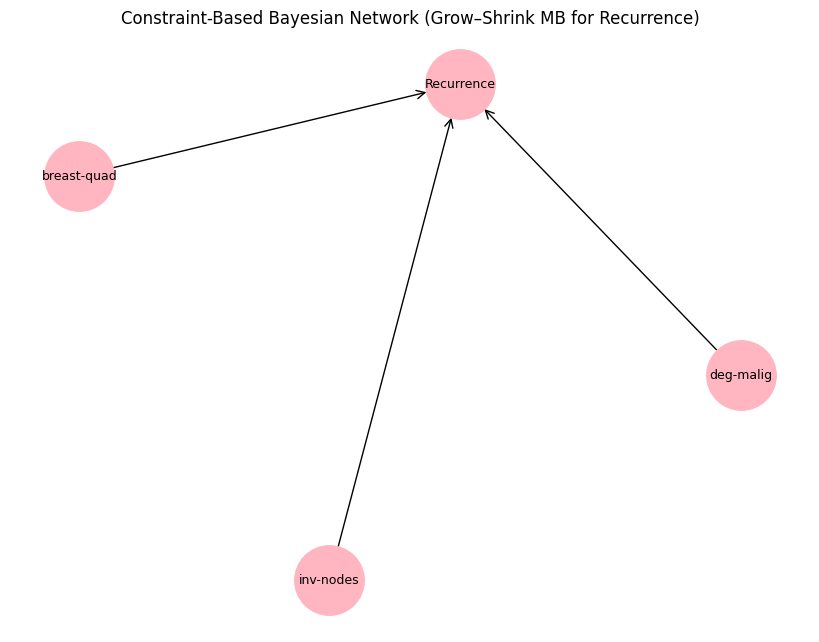

In [24]:
G = nx.DiGraph()

# Add nodes
G.add_node(target_col)
for f in features:
    G.add_node(f)
    G.add_edge(f, target_col)

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G, pos,
    with_labels=True,
    node_size=2500,
    node_color="lightpink",
    font_size=9,
    arrows=True,
    arrowstyle="->",
    arrowsize=15
)
plt.title("Constraint-Based Bayesian Network (Grow–Shrink MB for Recurrence)")
plt.show()
